# The standard Kalman filter with a linear predator-prey model, and filter divergence

* Emmanuel Cosme, 2017
* Illustrate the Kalman filter
* Update 2019: this notebook is a copy of Illustrate-Kalman-Filter-with-Linear-Predator-Prey-Model, extended to illustrate filter divergence (at the end)

This notebook illustrates data assimilation with the standard Kalman Filter implemented with a linear predator-prey model. I know predator-prey models should be nonlinear, but I make this one linear to remain within Kalman filter's optimal conditions and to make the model error effects clear; with nonlinear models, it is not straightforward to disentangle effects of model errors and nonlinearities.

The model describes the time evolution of the populations of predators ($x_0$), preys ($x_1$), and sources of preys ($x_2$). The dynamical model takes the following form:
$$ \frac{dx_0}{dt} = -0.1 x_0 + 0.2 x_1 $$
$$ \frac{dx_1}{dt} = -0.2 x_0 + x_2 $$

In the (simulated) real world, the source of carrots varies with season (with $t$ in days):
$$ x_2(t) = 4 \times \left( 1 + 0.8 \times \sin \left(\frac{2\pi t}{365} \right) \right) $$
If we do not know the source evolution, it can simply be simulated with persistence:
$$ \frac{dx_2}{dt} = 0 $$

The model is implemented as a class, below. The `forecast` function of this class propagates in time not only the state ${\bf x}=(x_0, x_1, x_2)$ of the model, but also the covariance matrix. This is made using a square-root decomposition of the covariance matrix and by propagating each column of this square-root. The class also includes basic plotting functions.

Here, the problem tackled by data assimilation is to retrieve the source term ($x_2$) using observations of the other variables (predators, typically), and not knowing the seasonal dynamics of the source: We assume persistence.

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

#-------------------------------------------------------
# Linear predator-prey model
#-------------------------------------------------------

class Model:
    """Linear predator-prey model. The state vector is composed of predators, preys, and prey source.
    When assim_mode is 'T', the assimilation mode is activated:
    - the covariance matrix is propagated (useless for a reference run)
    - the prey source is set constant for the state, 0 for the covariance matrix
    - model noise in the reference run to simulate uncertainties """

    def __init__( self, day_init = 0, day_stop = 365, assim_mode='T'):
        self.day_init = day_init
        self.day_stop = day_stop
        self.nday = self.day_stop - self.day_init
        self.assim_mode = assim_mode
        self.nx = 3                         # number of variables
        self.xvar, self.pmat, self.qmat = self.initial_condition()
        self.time = self.day_init
        self.xvar_series = np.empty(( self.nx, self.nday ))
        self.pmat_series = np.empty(( self.nx, self.nx, self.nday ))
        self.time_series = np.empty( self.nday )
        
    def initial_condition(self):
        """Define the initial condition"""
        xout = np.array( [ 5., 20., 2. ])
        if self.assim_mode != 'T':
            xout = np.array([8., 16., 4.])
        pout = np.array( [ [40., 0., 0.], [0., 40., 0.], [0., 0., 10.] ])
        qout = np.array( [ [0.5, 0., 0.], [0., 1., 0.], [0., 0., 0.25] ])
        return xout, pout, qout
        
    def time_step(self, x_in, day_in):    
        """Advance a linear-prey state vector from day_start to day_end"""
        x_out = np.zeros_like(x_in)
        x_out[0] = x_in[0] + ( - 0.1 * x_in[0] + 0.2 * x_in[1] )
        x_out[1] = x_in[1] + ( -0.2 * x_in[0] + x_in[2] )
        if self.assim_mode == 'T':
            x_out[2] = x_in[2]
        else:
            x_out[2] = 4. * ( 1. + 0.8*np.sin(2.*np.pi*day_in/365.))
        if self.assim_mode != 'T':
            x_out += np.random.multivariate_normal(np.zeros(self.nx), self.qmat)
        self.time = day_in
        return x_out
            
    def forecast(self, day_start = None, day_end = None):
        """Forecast of linear predator-prey model."""
        ## Initialisations
        if day_start == None or day_end == None:
            day_start = self.day_init
            day_end = self.day_stop
        nstep = day_end - day_start
        
        for day in range(day_start, day_end):
            iday = day - self.day_init
            if iday < 0:
                print 'Pb: Simulation starts before the initial day'
            
            ## Forecast of state
            self.xvar = self.time_step(self.xvar, day)
            self.xvar_series[:,iday] = self.xvar
            self.time_series[iday] = self.time
       
            ## Forecast of covariance matrix
            if self.assim_mode == 'T':
            ### Square-root decomposition of covariance matrix
                U, s, V = np.linalg.svd(self.pmat)
                S = np.diag(np.sqrt(s))
                smat=np.inner(U,S)
            ### Forecast each column of smat without source
                for ix in range(self.nx):
                    smat[:, ix] = self.time_step(smat[:,ix], day)
                self.pmat = np.dot(smat, smat.T) + self.qmat
                self.pmat_series[:, :, iday] = self.pmat
          
    def plot(self, time_ref = None, xvar_ref = None):
        plt.figure(figsize=(12,8))
        legend = ['Predator', 'prey', 'Prey source']
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            if not (time_ref is None and xvar_ref is None):
                plt.plot(time_ref,xvar_ref[ix,:],'red',linewidth=1.,label='Reference')
            plt.plot(self.time_series[:],self.xvar_series[ix,:],'black',linewidth=2.,label=legend[ix])
            plt.legend()
        plt.show()
        
    def plot_variance(self, time_ref = None, pmat_ref = None):
        plt.figure(figsize=(12,8))
        legend = ['Predator', 'prey', 'Prey source']
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            plt.plot(self.time_series[:],self.pmat_series[ix,ix,:],'black',linewidth=2.,label=legend[ix])
            plt.legend()
        plt.show()
        
    def plot_correlation(self, n1, n2):
        plt.figure(figsize=(12,3))
        legend = ['Predator', 'prey', 'Prey source']
        corr = self.pmat_series[n1,n2,:]/np.sqrt(self.pmat_series[n1,n1,:]*self.pmat_series[n2,n2,:])
        plt.plot(self.time_series[:],corr,'black',linewidth=2.,label=(legend[n1], legend[n2]))
        plt.legend()
        plt.show()

# Making the real world
We first simulate the "real world": the simulation below is performed using the seasonal evolution of the source term. It also includes some random perturbations, typically due to small processes not represented by the model (migration of predators, fluctuations in the growing rate of carrots, etc). This simulation is called the **reference** and observations will be extracted from it for assimilation. The plots below shows the time evolution of all three variables over one year.

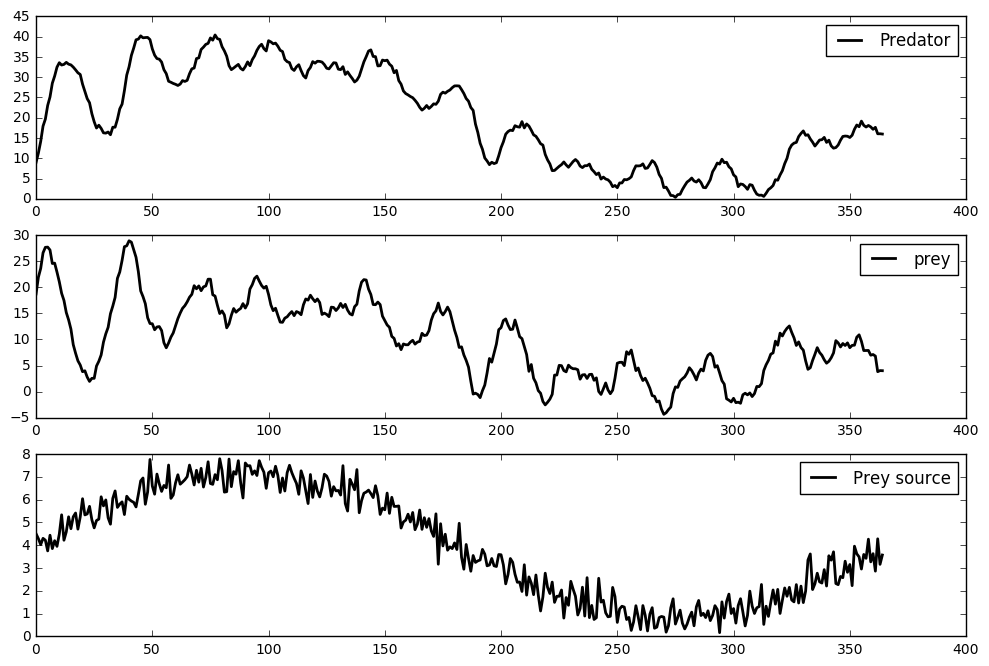

In [2]:
PP_ref = Model(assim_mode='F')
PP_ref.forecast()
PP_ref.plot()
true_state = PP_ref.xvar_series
true_time = PP_ref.time_series

# Data assimilation
Remember that the Kalman filter analysis is performed with the Best Linear Unbiased Estimate (BLUE) equations. A function to perform this analysis is defined here.

In [3]:
def blue(xf,Pf,yobs,Robs,Hobs):
    """compute the BLUE solution"""
    HPf=np.dot(Hobs,Pf)
    InnovM=np.dot(Hobs,np.transpose(HPf))+Robs
    Innovation=yobs-np.dot(Hobs,xf)
    if np.shape(InnovM)[0]==1:
        Kgain=np.transpose(HPf)/InnovM
        xa=xf+np.dot(Kgain,Innovation)
        Pa=Pf-np.outer(Kgain,HPf)
    else:  
        Kgain=np.dot(np.transpose(HPf),np.linalg.inv(InnovM))
        xa=xf+np.dot(Kgain,Innovation)
        Pa=Pf-np.dot(Kgain,HPf)
    return xa,Pa   

## Assimilation setup
We define the assimilation setup: first and last days, observed variable (in `nvarobs`), error statistics, days at which observations are available.

In [4]:
#nvarobs = 0
#nvarobs = [0, 1]
day_start, day_end = 0, 360
ntime = day_end - day_start
nvarobs = [0]
nobs = len(nvarobs)
Robs = 1.e-4*np.eye(nobs)
Hobs = np.zeros( (nobs,3) )
for io in range(nobs):
    Hobs[io,nvarobs[io]] = 1.
assim_days = range(20,360,10)
nassim = len(assim_days)
lencycle = np.hstack((assim_days[0], np.ediff1d(assim_days)))

## Without assimilation of observations
We first perform a Kalman filter simulation without assimilating observations. The initial state and the source term are different from the reference simulation. The source term, in particular, is constant. Below are plotted the evolution of all variables, along with the reference simulation for comparison. And below, the error variances (diagonal terms of the covariance matrix) are plotted. The variances grows due to the model error term in particular.

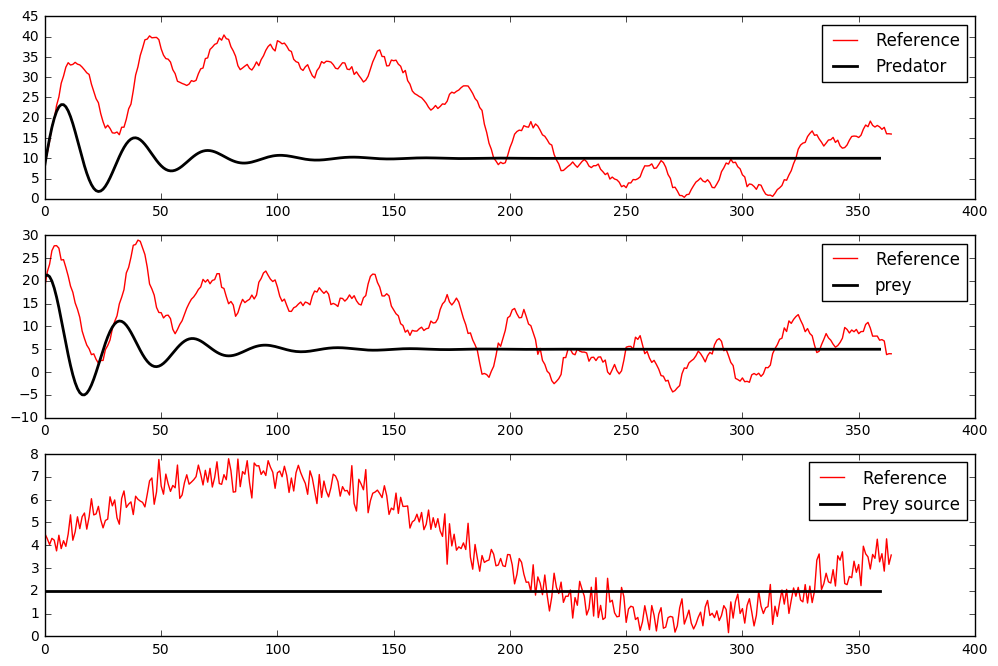

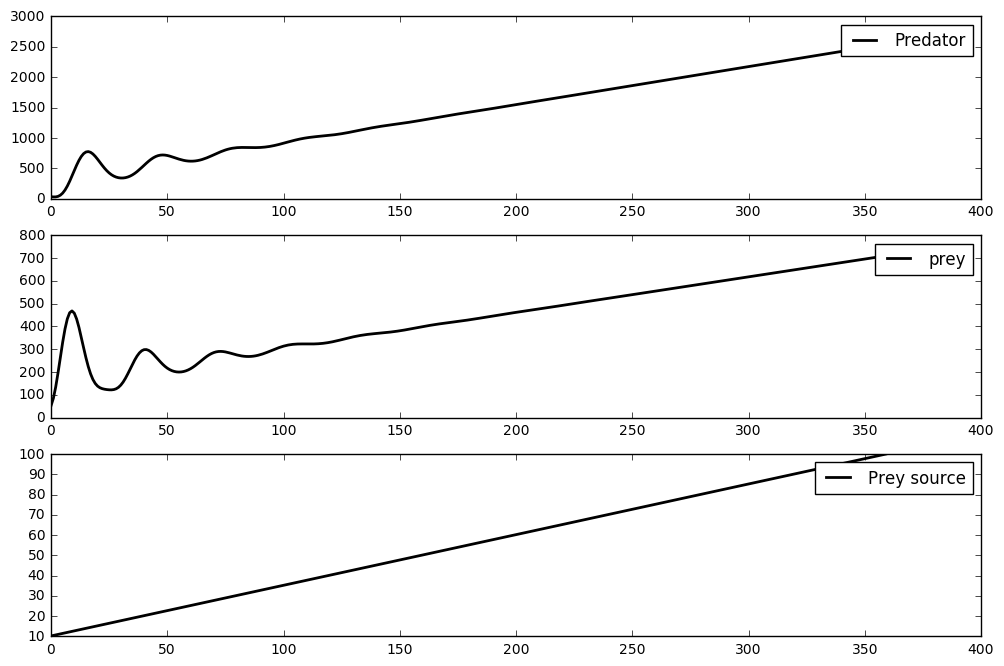

In [5]:
PP_free = Model(day_init = day_start, day_stop = day_end)
#PP_free.qmat = np.array( [ [0.5, 0., 0.], [0., 1., 0.], [0., 0., 3.] ])
PP_free.forecast()
PP_free.plot(time_ref=true_time, xvar_ref=true_state)
PP_free.plot_variance()


## Kalman filtering
We now cycle the Kalman filter assimilating observations and plot the results in the same format as previously. Note that the filter can approximately retrieve the source term, although the model used does not know the seasonal dynamics.

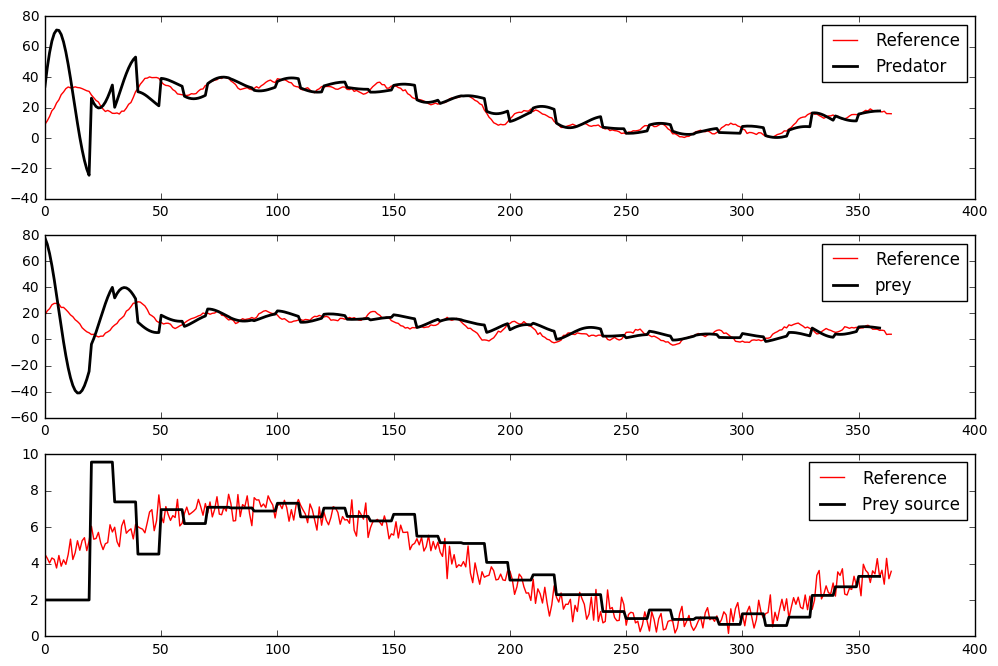

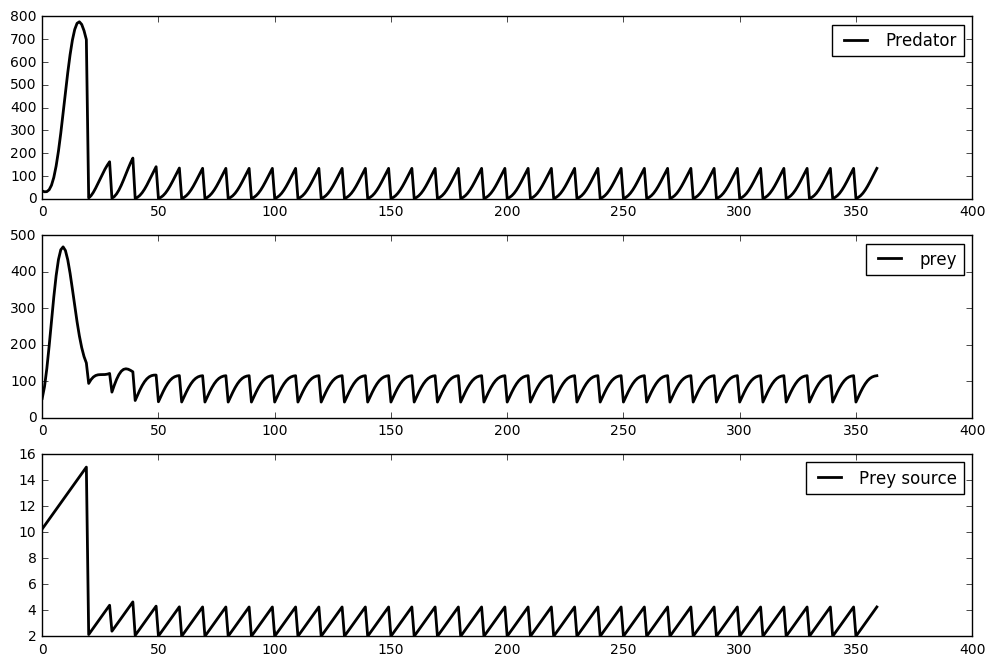

In [6]:
PP_KF = Model(day_init = day_start, day_stop = day_end)
PP_KF.xvar[0:2] *= 4.

for ic in range(nassim):
    
    ## Forecast
    if ic == 0:
        day1 = day_start
    else:
        day1 = assim_days[ic-1]
    day2 = assim_days[ic]

    PP_KF.forecast(day1, day2)
        
    ## Analysis
    obs_index = np.argwhere( true_time == PP_KF.time )
    yobs = true_state[nvarobs, obs_index].squeeze()                 # without noise for simplicity
    
    PP_KF.xvar, PP_KF.pmat = blue( PP_KF.xvar, PP_KF.pmat, yobs, Robs, Hobs )
       
## Last cycle
if day_end > assim_days[-1]:
    PP_KF.forecast(assim_days[-1], day_end)

## Plots
PP_KF.plot(time_ref=true_time, xvar_ref=true_state)
PP_KF.plot_variance()


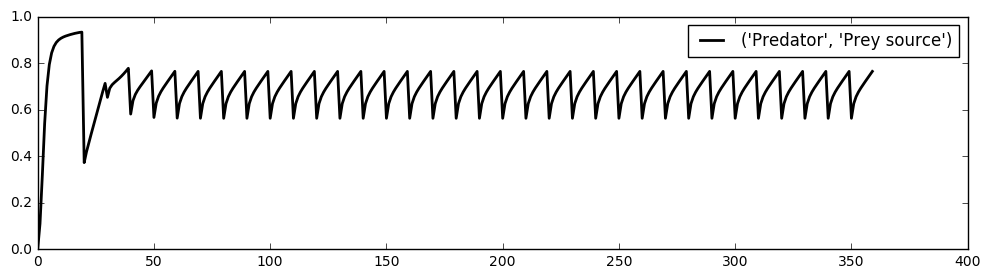

In [7]:
PP_KF.plot_correlation(0,2)

## Illustrate filter divergence

Below, we set up a case where the observations above are increased by 30, and the initial covariance matrix is significantly reduced.

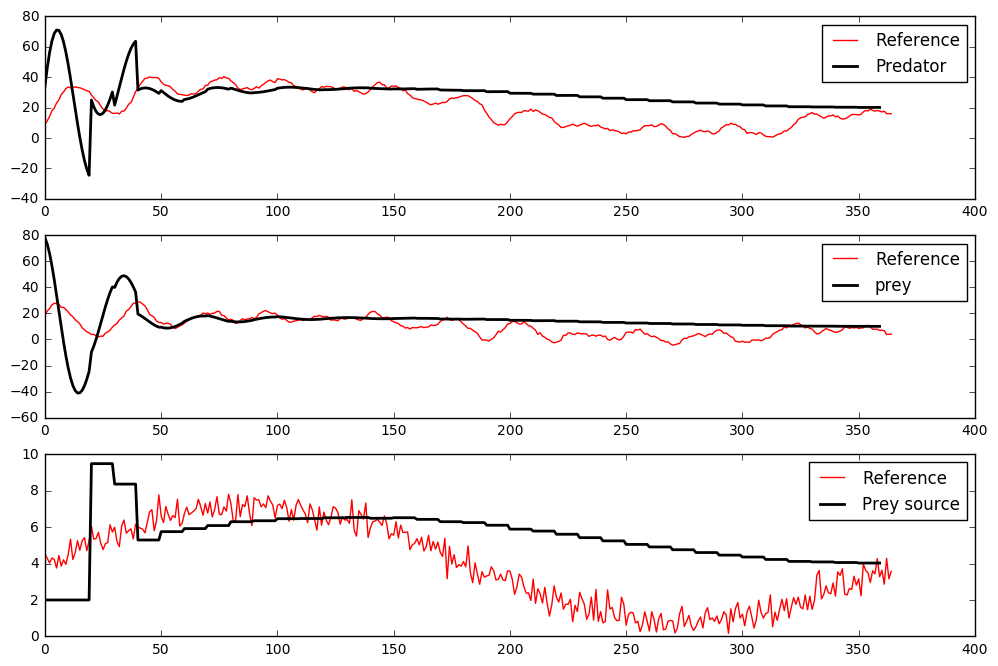

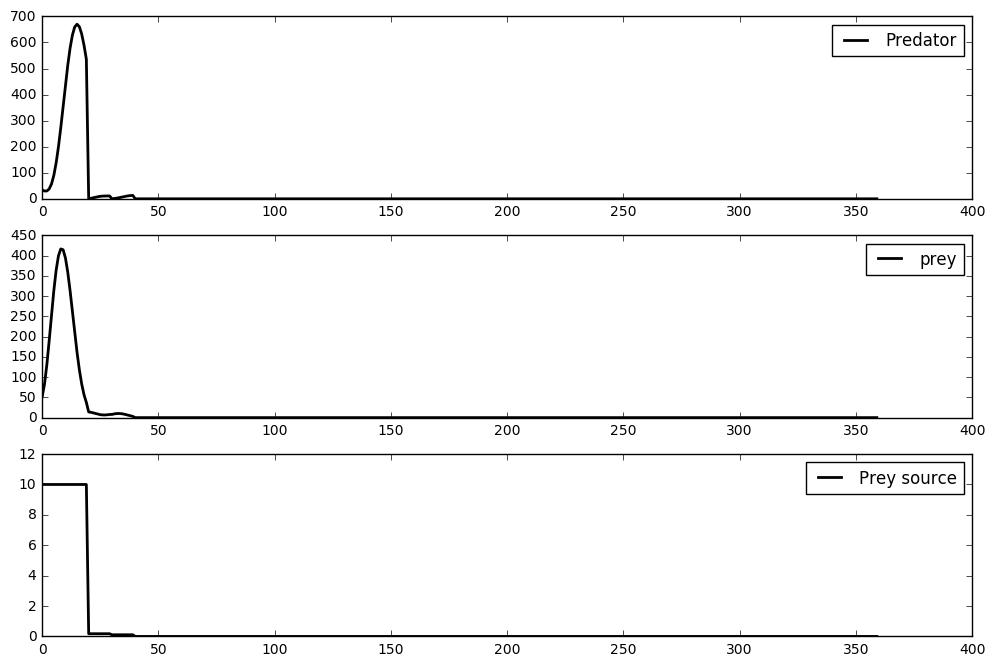

In [8]:
PP_KF = Model(day_init = day_start, day_stop = day_end)
PP_KF.qmat /= 1e12    # 1st modification
PP_KF.xvar[0:2] *= 4.

for ic in range(nassim):
    
    ## Forecast
    if ic == 0:
        day1 = day_start
    else:
        day1 = assim_days[ic-1]
    day2 = assim_days[ic]

    PP_KF.forecast(day1, day2)
        
    ## Analysis
    obs_index = np.argwhere( true_time == PP_KF.time )
    yobs = true_state[nvarobs, obs_index].squeeze()         
    
    PP_KF.xvar, PP_KF.pmat = blue( PP_KF.xvar, PP_KF.pmat, yobs, Robs, Hobs )
       
## Last cycle
if day_end > assim_days[-1]:
    PP_KF.forecast(assim_days[-1], day_end)

## Plots
PP_KF.plot(time_ref=true_time, xvar_ref=true_state)
PP_KF.plot_variance()
